# Derivative of a GP

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/derivativegp/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/derivativegp/).*

The derivative of a GP is also a GP, as differentiation is a linear operators. In this example, we show how to use of the `DerivativeGP` and how to easily generate it from a known GP.

## 1D Example

### Setup

In [1]:
using GPDiffEq
using Plots
using LinearAlgebra
using Zygote

### The toy model
We generate data for our model

In [2]:
σ_n = 3e-2
x = collect(range(-3, 3; length=10))
y = sin.(x) + σ_n * randn(length(x))

10-element Vector{Float64}:
 -0.12274231071735937
 -0.7419941090203287
 -1.0372257051245795
 -0.7742915005946704
 -0.3006582685792487
  0.29141344836015304
  0.8956730647339963
  0.9540796556206577
  0.7225145857673094
  0.11985069591236902

which looks as follows

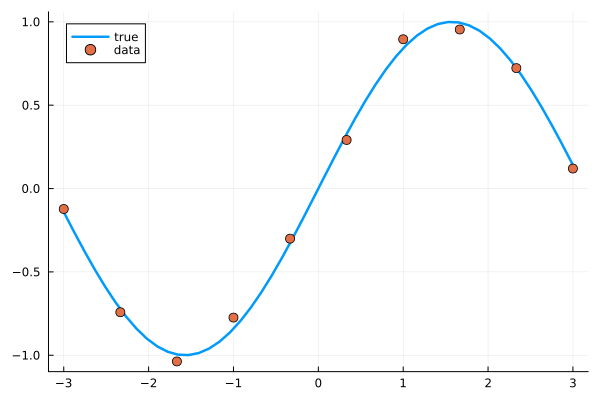

In [3]:
x_plot = collect(range(-3, 3; length=50))

plot(x_plot, sin.(x_plot); label="true", linewidth=2.5)
scatter!(x, y; label="data", markersize=5)
plot!(; legend=:topleft) #hide

### Define a GP
We'll use a simple GP with a `ZeroMean` and `GaussianKernel`, condition it on our data

In [4]:
kernel = GaussianKernel()
f = GP(kernel)
fx = f(x, σ_n^2)

f_post = posterior(fx, y)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))), (α = [0.9073661072389199, -1.2660364589087603, 0.795478308551613, -3.845976639064311, 7.62863314964323, -11.966312755831973, 14.524288126250951, -12.32394786993952, 8.904589760254165, -3.592667998740037], C = LinearAlgebra.Cholesky{Float64, Matrix{Float64}}([1.0004498987955368 0.8003773141272065 … 6.655367228157499e-7 1.5223130876467006e-8; 0.8007374029168073 0.6002467451228027 … 3.0207225222272073e-5 1.0889719997540142e-6; … ; 6.658361469857302e-7 1.8664469113520537e-5 … 0.3482835414112316 0.6956902200185071; 1.5229979744712

and plot the posterior. Note that this GP completely untrained, no hyperparameters have been defined.

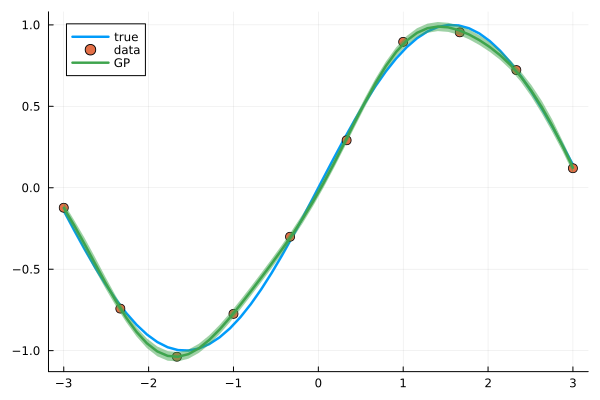

In [5]:
plot(x_plot, sin.(x_plot); label="true", linewidth=2.5)
scatter!(x, y; label="data", markersize=5)
plot!(
    x_plot,
    mean(f_post, x_plot);
    ribbons=sqrt.(var(f_post, x_plot)),
    label="GP",
    linewidth=2.5,
)
plot!(; legend=:topleft) #hide

### Derivative of a GP
Now we can easily generate the derivate of this GP

In [6]:
df_post = differentiate(f_post)

AbstractGPs.PosteriorGP{GPDiffEq.DerivativeGPModule.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, AbstractGPs.ZeroMean{Float64}, GPDiffEq.DerivativeGPModule.DerivativeKernelCollection{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}}}}(GPDiffEq.DerivativeGPModule.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, AbstractGPs.ZeroMean{Float64}, GPDiffEq.DerivativeGPModule.DerivativeKernelCollection{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))), AbstractGPs.ZeroMean{Float64}(), GPDiffEq.DerivativeG

and plot the new posterior. As we know, the derivative of `sin` is `cos`, so we can check the differentiated GP.

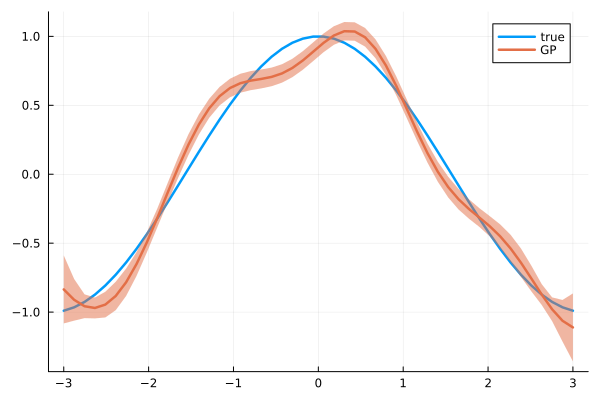

In [7]:
plot(x_plot, cos.(x_plot); label="true", linewidth=2.5)
plot!(
    x_plot,
    mean(df_post, x_plot);
    ribbons=sqrt.(var(df_post, x_plot)),
    label="GP",
    linewidth=2.5,
)

As we saw above, the original GP was slighly off from the true function. This is reflected and amplified in the derivative as well.

## 2D Example

We can do the same for a Multi-Input-Multi-Output GP, using the KernelFunctions.jl [multi-output interface](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/api/#Inputs-for-Multiple-Outputs).

### Setup

In [8]:
function fun(x)
    return [-0.1 2.0; -2.0 -0.1] * (x .^ 3)
end
xrange = range(-1, 1; length=4)
x = collect.(Iterators.product(xrange, xrange))[:]
y = fun.(x)
# This is annoying UX, needs fix
y = ColVecs(reduce(hcat, y))
xMO, yMO = prepare_isotopic_multi_output_data(x, y)

([([-1.0, -1.0], 1), ([-1.0, -1.0], 2), ([-0.3333333333333333, -1.0], 1), ([-0.3333333333333333, -1.0], 2), ([0.3333333333333333, -1.0], 1), ([0.3333333333333333, -1.0], 2), ([1.0, -1.0], 1), ([1.0, -1.0], 2), ([-1.0, -0.3333333333333333], 1), ([-1.0, -0.3333333333333333], 2)  …  ([1.0, 0.3333333333333333], 1), ([1.0, 0.3333333333333333], 2), ([-1.0, 1.0], 1), ([-1.0, 1.0], 2), ([-0.3333333333333333, 1.0], 1), ([-0.3333333333333333, 1.0], 2), ([0.3333333333333333, 1.0], 1), ([0.3333333333333333, 1.0], 2), ([1.0, 1.0], 1), ([1.0, 1.0], 2)], [-1.9, 2.1, -1.9962962962962962, 0.17407407407407408, -2.0037037037037035, 0.025925925925925936, -2.1, -1.9, 0.025925925925925936, 2.0037037037037035  …  -0.025925925925925936, -2.0037037037037035, 2.1, 1.9, 2.0037037037037035, -0.025925925925925936, 1.9962962962962962, -0.17407407407407408, 1.9, -2.1])

### Defining a Multi-Output GP

In [9]:
σ_n = 3e-2
ker = GaussianKernel()
mker = IndependentMOKernel(ker)

f = GP(mker)
fx = f(xMO, σ_n)
f_post = posterior(fx, yMO)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{Vector{Float64}, Vector{Vector{Float64}}, Int64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}(AbstractGPs.ZeroMean{Float64}(), Independent Multi-Output Kernel
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))), (α = [-5.8928082251502145, 6.513103827797586, -3.584099275931157, -9.35081487416016, -2.6334738556861117, 9.66169353074103, -6.513103827797586, -5.8928082251502, 9.661693530741045, 2.633473855686111  …  -9.661693530741022, -2.6334738556861064, 6.513103827797607, 5.892808225150211, 2.633473855686087, -9.661693530741033, 3.584099275931181, 9.3508148

which looks as follows

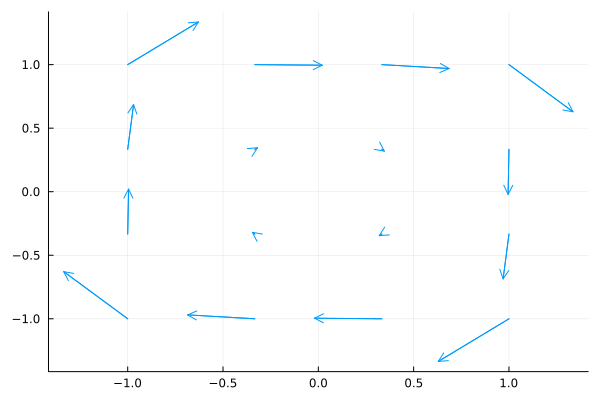

In [10]:
sf = maximum(norm.(y)) * 2
quiver(
    getindex.(xMO.x, 1),
    getindex.(xMO.x, 2);
    quiver=(y.X[1, :] ./ sf, y.X[2, :] ./ sf),
    label="data",
    markersize=5,
)

### Derivative of a Multi-Output GP

As above, the derivate is obtained very easily using our provided function:

In [11]:
df_post = differentiate(f_post)

AbstractGPs.PosteriorGP{GPDiffEq.DerivativeGPModule.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, AbstractGPs.ZeroMean{Float64}, GPDiffEq.DerivativeGPModule.DerivativeKernelCollection{KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{Vector{Float64}, Vector{Vector{Float64}}, Int64}, Vector{Float64}}}}(GPDiffEq.DerivativeGPModule.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, AbstractGPs.ZeroMean{Float64}, GPDiffEq.DerivativeGPModule.DerivativeKernelCollection{KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}}(AbstractGPs.GP{AbstractGPs.ZeroM

### Visualizing the derivatives
To demonstrate, we we show the contour plots for each component of our function and the corresponding (scaled) gradient separately.
In the first row of the following grid we show the $f_1$ and in the second row $f_2$.
The right column showing the GP also includes the location of the input data points for the GP.

As our GP is untrained, it smoothes the data a little too strongly, but we can see that the gradients are correctly perpendicular to the contours.

┌ Warning: Assignment to `sf` in soft scope is ambiguous because a global variable by the same name exists: `sf` will be treated as a new local. Disambiguate by using `local sf` to suppress this warning or `global sf` to assign to the existing global variable.
└ @ ~/work/GPDiffEq.jl/GPDiffEq.jl/docs/src/examples/derivativegp.ipynb:55


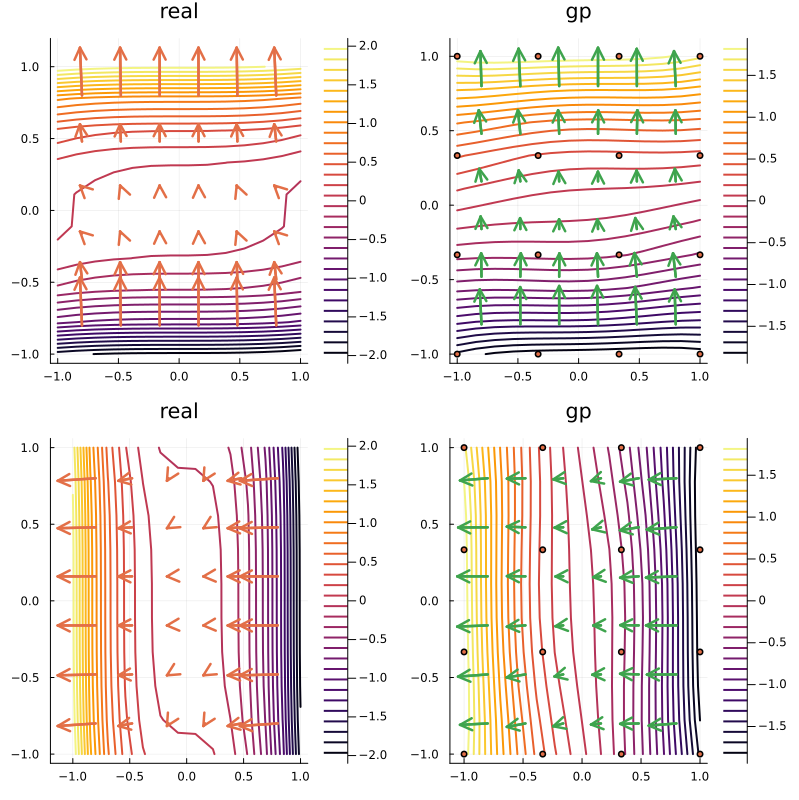

In [12]:
xprange = range(-1, 1; length=14)
xprange2 = range(-1, 1.0; length=10)
xp = vcat.(xprange', xprange2)

p = plot(; layout=(2, 2), size=(800, 800))

for comp in 1:2
    nlevels = 30
    narrow = 6

    spl = (comp - 1) * 2
    fungrad(xval) = only(gradient(x -> fun(x)[comp], xval))
    gpgrad(xval) = only(mean(df_post, [(xval, comp)]))
    zreal = getindex.(fun.(xp), comp)

    contour!(
        p,
        xprange,
        xprange2,
        zreal;
        levels=nlevels,
        linewidth=2,
        label="",
        subplot=spl + 1,
        title="real",
    )

    xpMO = [[(xval, comp)] for xval in xp]
    zgp = only.(mean.(Ref(f_post), xpMO))
    contour!(
        p,
        xprange,
        xprange2,
        zgp;
        levels=nlevels,
        linewidth=2,
        label="",
        subplot=spl + 2,
        title="gp",
    )

    scatter!(
        p,
        getindex.(x, 1),
        getindex.(x, 2);
        label="data",
        markersize=3,
        subplot=spl + 2,
        legend=:none,
    )

    xgrange = range(-0.8, 0.8; length=narrow)
    xg = collect.(Iterators.product(xgrange, xgrange))[:]
    dzreal = fungrad.(xg)
    sf = maximum(norm.(dzreal)) * 3

    quiver!(
        p,
        getindex.(xg, 1),
        getindex.(xg, 2);
        quiver=(getindex.(dzreal, 1) ./ sf, getindex.(dzreal, 2) ./ sf),
        label="data",
        linewidth=2.5,
        subplot=spl + 1,
    )

    dzgp = gpgrad.(xg)
    quiver!(
        p,
        getindex.(xg, 1),
        getindex.(xg, 2);
        quiver=(getindex.(dzgp, 1) ./ sf, getindex.(dzgp, 2) ./ sf),
        label="data",
        linewidth=2.5,
        subplot=spl + 2,
    )
end
p

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*